# Analysis of 'Siebenkampf' and Multivariate Gaussian Distribution

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
data_dir = Path.cwd().parents[1] / "_data"

assert data_dir.exists(), data_dir
list(data_dir.glob("*.csv"))

[PosixPath('/Users/jd/Desktop/repos/ama_ws25/_data/siebenkampf.csv'),
 PosixPath('/Users/jd/Desktop/repos/ama_ws25/_data/life_expectancy_data.csv')]

In [ ]:
df = pd.read_csv(data_dir / "siebenkampf.csv", sep=";", decimal=",")

df = (
    df.drop(columns=df.columns[0])
    .assign(
        birth_date=lambda x: pd.to_datetime(x["Gebutsdatum"], errors="coerce"),
        # year is given; summer games in july, assuming 15.07
        jahr=lambda x: pd.to_datetime(x.jahr.astype(str) + "-07-15", errors="coerce"),
    )
    .drop(columns=["Gebutsdatum"])
    .assign(
        Zeit_800m_Lauf=lambda x: x.Zeit_800m_Lauf_Minute / 100
        + x.Zeit_800m_Lauf_Sekunden
    )
    .drop(columns=["Zeit_800m_Lauf_Minute", "Zeit_800m_Lauf_Sekunden"])
)
df

,Platzierung,Name,Punkte85,Land,jahr,wettkamp,Zeit_100m_Huerden,Hochsprung,Kugelstoßen,Zeit_200m_Lauf,Weitsprung,Speerwurf,Quelle,birth_date,Zeit_800m_Lauf
0,1,Glynis Nunn,6387,Austr.,1984-07-15,Olympische Spiele,13.02,1.80,12.82,24.06,6.66,35.58,sports-reference.com,1960-12-04,208.57
1,2,Jackie Joyner-Kersee,6363,USA,1984-07-15,Olympische Spiele,13.63,1.80,14.39,24.05,6.11,44.52,sports-reference.com,1962-03-03,212.83
2,3,Sabine Everts,6388,BRD,1984-07-15,Olympische Spiele,13.54,1.89,12.49,24.05,6.71,32.62,sports-reference.com,1961-03-04,206.45
3,4,Cindy Greiner,6249,USA,1984-07-15,Olympische Spiele,13.71,1.83,13.36,24.40,6.15,40.86,sports-reference.com,1957-02-15,210.35
4,5,Judy Livermore-Simpson,6264,GB,1984-07-15,Olympische Spiele,13.07,1.86,13.86,24.95,6.33,33.64,sports-reference.com,1960-11-14,212.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,6,Sharon Day,6407,USA,2013-07-15,Weltmeisterschaften,13.51,1.83,14.35,24.28,5.79,47.17,www.iaaf.org,1985-06-09,205.74
206,7,Eliška Klu?inová,6332,CZE,2013-07-15,Weltmeisterschaften,13.97,1.86,14.19,24.91,6.12,45.76,www.iaaf.org,1988-04-14,211.70
207,8,Antoinette Nana Djimou I,6326,FRA,2013-07-15,Weltmeisterschaften,13.36,1.77,14.54,24.95,5.97,52.47,www.iaaf.org,1985-08-02,221.24
208,9,Karolina Tyminska,6270,Polen,2013-07-15,Weltmeisterschaften,13.48,1.68,13.74,24.13,6.32,40.61,www.iaaf.org,1984-10-04,202.24


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Platzierung        210 non-null    int64         
 1   Name               210 non-null    object        
 2   Punkte85           210 non-null    int64         
 3   Land               209 non-null    object        
 4   jahr               210 non-null    datetime64[ns]
 5   wettkamp           210 non-null    object        
 6   Zeit_100m_Huerden  210 non-null    float64       
 7   Hochsprung         210 non-null    float64       
 8   Kugelstoßen        210 non-null    float64       
 9   Zeit_200m_Lauf     210 non-null    float64       
 10  Weitsprung         210 non-null    float64       
 11  Speerwurf          210 non-null    float64       
 12  Quelle             210 non-null    object        
 13  birth_date         210 non-null    datetime64[ns]
 14  Zeit_800m_

In [ ]:
# Für wie viele unterschiedliche Sportlerinnen enthält der Datensatz Beobachtungen?
len(df), df.Name.nunique()

(210, 115)

In [ ]:
# Wie viele unterschiedliche Nationalitäten sind vertreten?
df.Land.nunique()

40

In [ ]:
# Berechnen Sie aus dem Jahr des Geburtsdatums und dem Wettkampfjahr das Alter der Sportlerinnen zum Zeitpunkt des Wettkampfes. Bestimmen Sie Mittelwert und Standardabweichung des Alters. Visualisieren Sie das Alter geeignet.
df = df.assign(age=(df.jahr - df.birth_date).dt.days // 365)
df.age.describe()

count    210.000000
mean      25.933333
std        3.546726
min       19.000000
25%       23.000000
50%       25.500000
75%       28.000000
max       35.000000
Name: age, dtype: float64

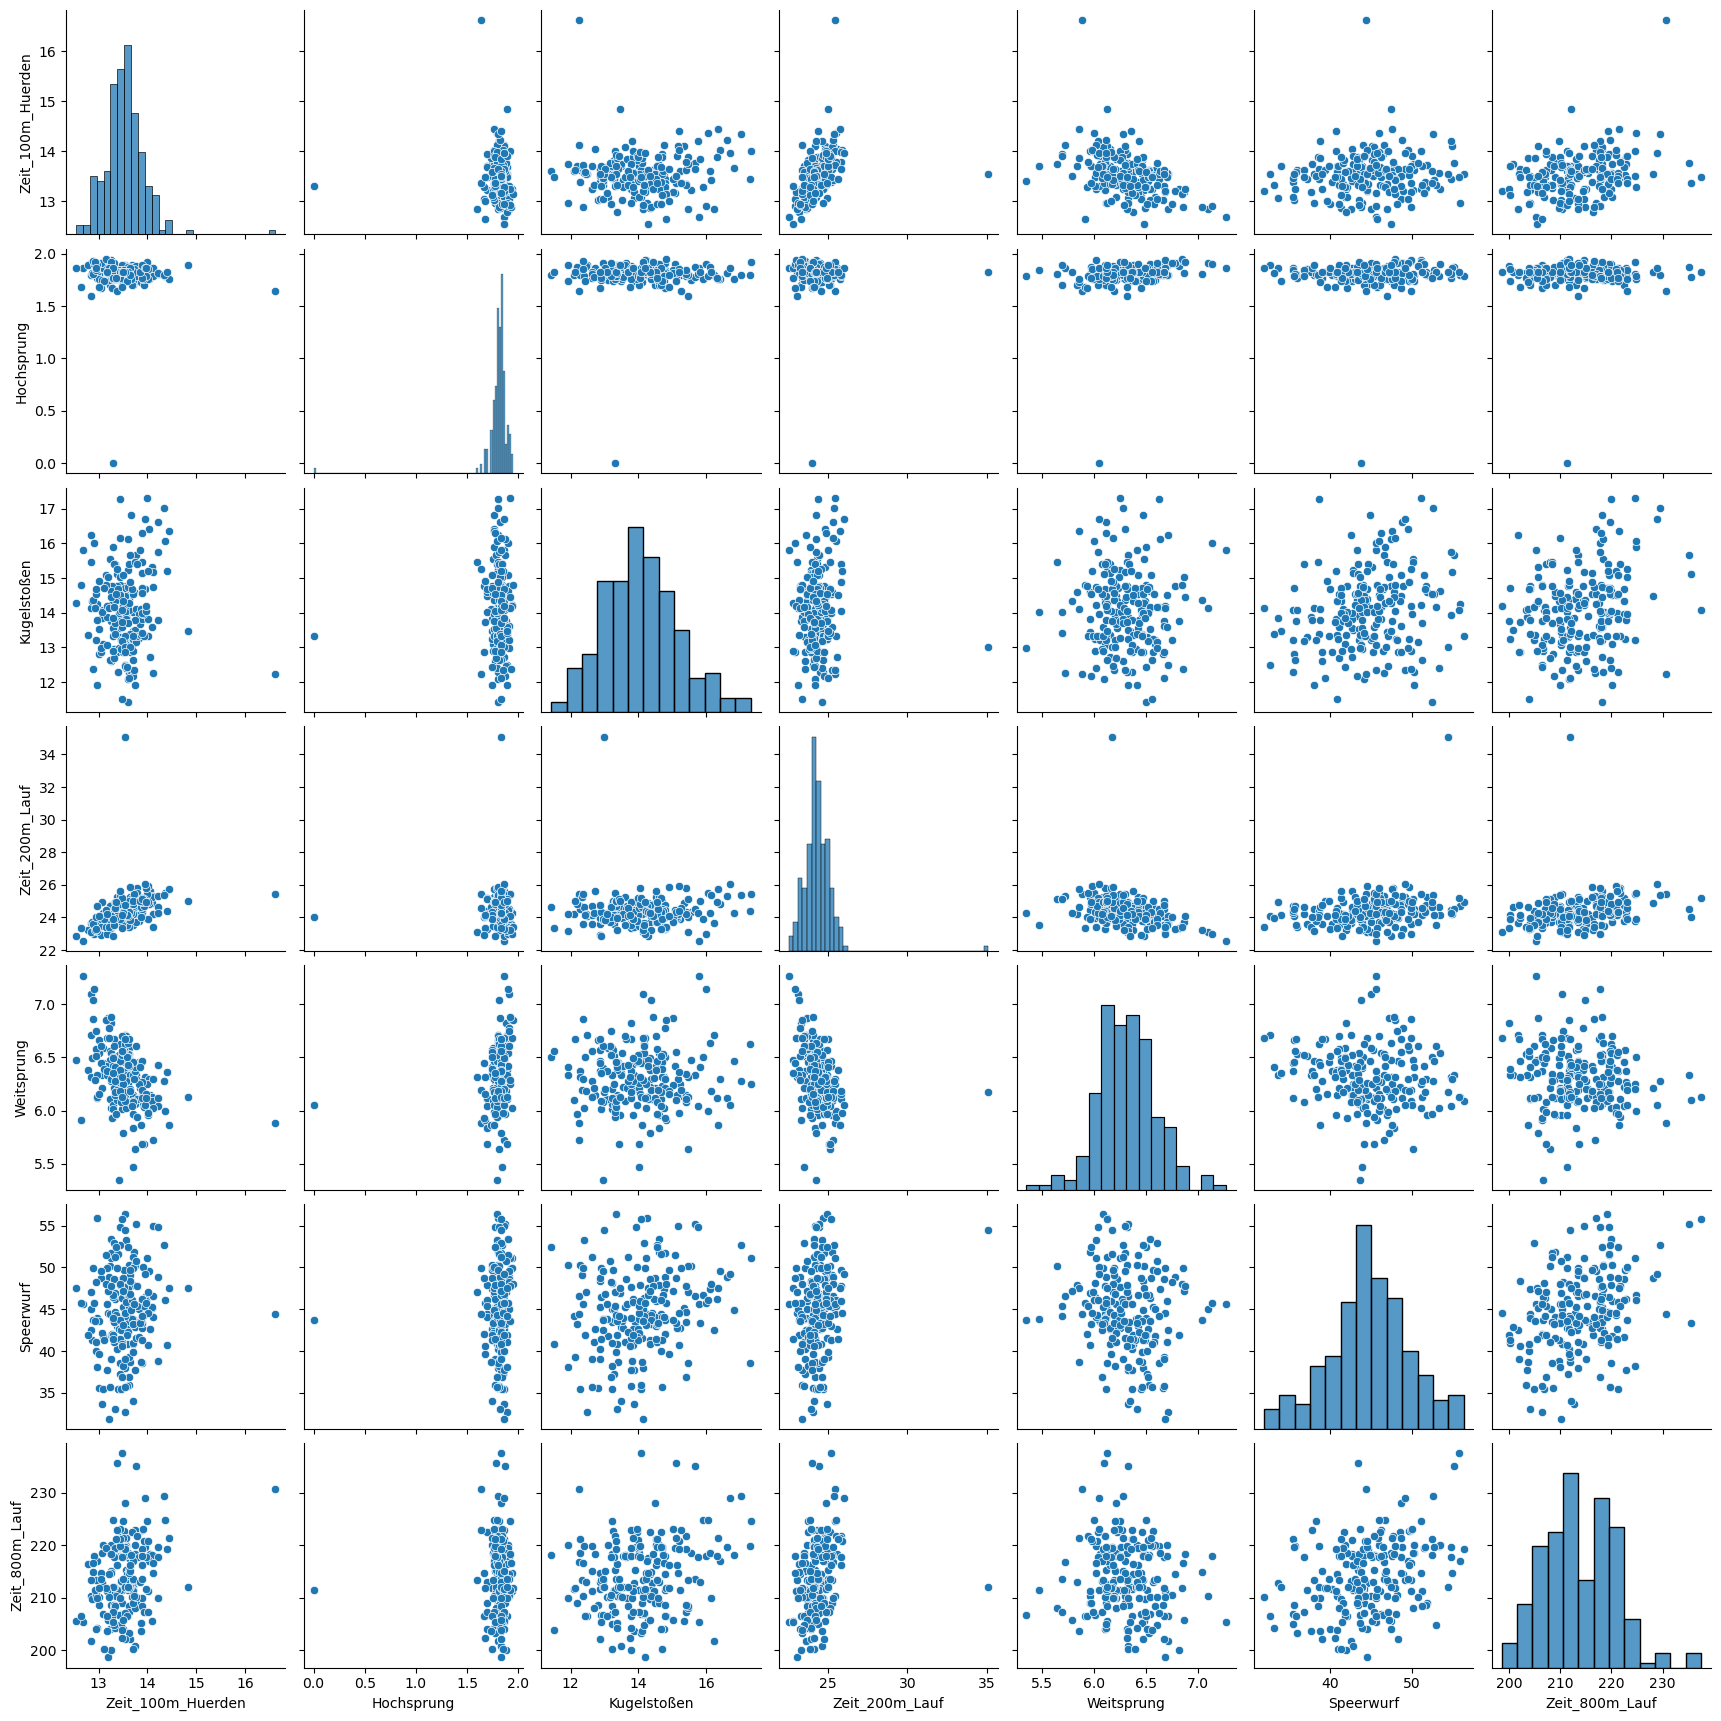

In [ ]:
disciplines = [
    "Zeit_100m_Huerden",
    "Hochsprung",
    "Kugelstoßen",
    "Zeit_200m_Lauf",
    "Weitsprung",
    "Speerwurf",
    "Zeit_800m_Lauf",
]

sns.pairplot(df[disciplines])
plt.show()

In [ ]:
df[disciplines].corr()

,Zeit_100m_Huerden,Hochsprung,Kugelstoßen,Zeit_200m_Lauf,Weitsprung,Speerwurf,Zeit_800m_Lauf
Zeit_100m_Huerden,1.000000,-0.022020,0.039563,0.388822,-0.431684,0.090405,0.301236
Hochsprung,-0.022020,1.000000,0.015389,0.002319,0.189726,0.031368,0.014086
Kugelstoßen,0.039563,0.015389,1.000000,0.023457,0.013463,0.193772,0.228249
Zeit_200m_Lauf,0.388822,0.002319,0.023457,1.000000,-0.337385,0.243697,0.268794
Weitsprung,-0.431684,0.189726,0.013463,-0.337385,1.000000,-0.150258,-0.116353
Speerwurf,0.090405,0.031368,0.193772,0.243697,-0.150258,1.000000,0.327955
Zeit_800m_Lauf,0.301236,0.014086,0.228249,0.268794,-0.116353,0.327955,1.000000


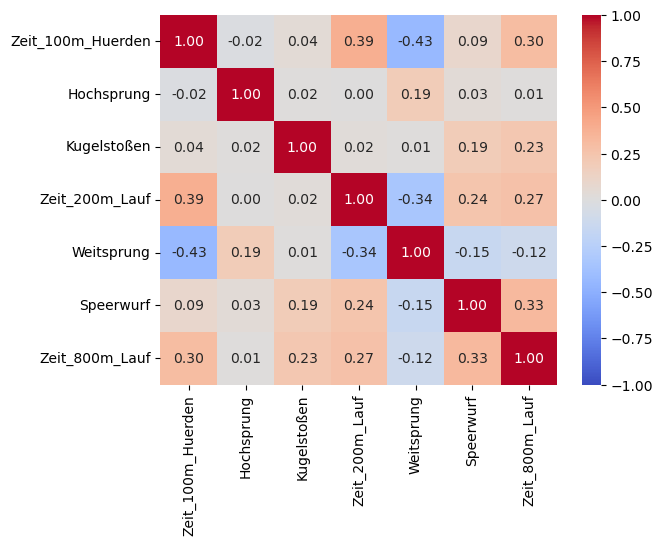

In [ ]:
sns.heatmap(
    df[disciplines].corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1
)
plt.show()

                                   pair  correlation
0   Zeit_100m_Huerden vs Zeit_200m_Lauf     0.388822
1           Speerwurf vs Zeit_800m_Lauf     0.327955
2   Zeit_100m_Huerden vs Zeit_800m_Lauf     0.301236
3      Zeit_200m_Lauf vs Zeit_800m_Lauf     0.268794
4           Speerwurf vs Zeit_200m_Lauf     0.243697
5         Kugelstoßen vs Zeit_800m_Lauf     0.228249
6              Kugelstoßen vs Speerwurf     0.193772
7              Hochsprung vs Weitsprung     0.189726
8        Speerwurf vs Zeit_100m_Huerden     0.090405
9      Kugelstoßen vs Zeit_100m_Huerden     0.039563
10              Hochsprung vs Speerwurf     0.031368
11        Kugelstoßen vs Zeit_200m_Lauf     0.023457
12            Hochsprung vs Kugelstoßen     0.015389
13         Hochsprung vs Zeit_800m_Lauf     0.014086
14            Kugelstoßen vs Weitsprung     0.013463
15         Hochsprung vs Zeit_200m_Lauf     0.002319
16      Hochsprung vs Zeit_100m_Huerden    -0.022020
17         Weitsprung vs Zeit_800m_Lauf    -0.

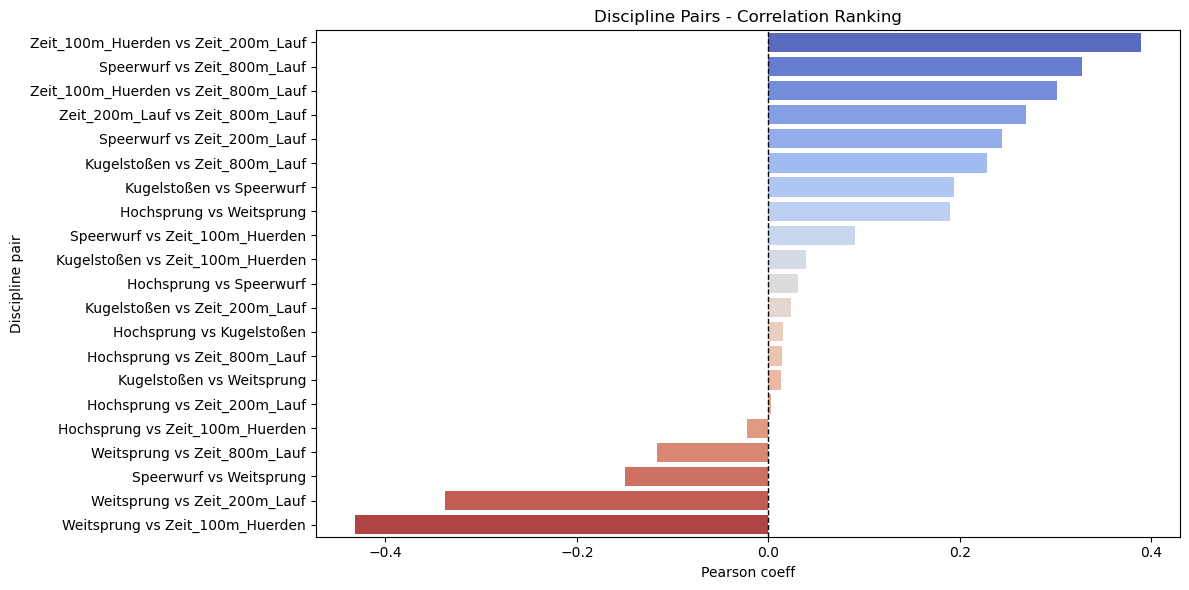

In [ ]:
# Sort all discipline pairs by their Pearson correlation and display the ranking
corr_pairs = (
    df[disciplines]
    .corr()
    .stack()
    .reset_index(name="correlation")
    .query("level_0 < level_1")  # keep each tuple only once!
    .assign(pair=lambda d: d.level_0 + " vs " + d.level_1)
    .sort_values("correlation", ascending=False)[["pair", "correlation"]]
    .reset_index(drop=True)
)
print(corr_pairs.to_string(index=True))

plt.figure(figsize=(12, 6))
sns.barplot(
    data=corr_pairs,
    x="correlation",
    y="pair",
    hue="pair",
    palette="coolwarm",
    legend=False,
)
plt.title("Discipline Pairs - Correlation Ranking")
plt.xlabel("Pearson coeff")
plt.ylabel("Discipline pair")
plt.axvline(0, color="black", linewidth=1, linestyle="--")
plt.tight_layout()
plt.show()

One issue in the correlation analysis is that a higher value for "Weitsprung" is good, whilst a lower value for "Laufzeit" is good. Hence, Laufzeit would need to be inverted!
  This could for example be done by:
- **Simple inversion (negative sign):**  
  `df = df.assign(Zeit_100m_Huerden_inv=lambda d: -d.Zeit_100m_Huerden, …)`  
  This keeps units but reverses direction. Lower times become larger (less negative) numbers, so a high jump correlating positively with `Zeit_100m_Huerden_inv` now reads as “better jump ↔ faster hurdles.”

- **Scaled inversion (e.g., 1/time or max–time):**  
  Choose something like `df.assign(Zeit_100m_Huerden_inv=lambda d: 1 / d.Zeit_100m_Huerden)` or `max_time - time`. This not only flips the direction but also changes the scale to emphasize relative improvements. Pick the transformation that best matches your interpretation; `1 / time` is common when times are strictly positive and you care about speed, while `max_time - time` preserves the range’s magnitude in seconds.

        age_group   avg_points  avg_rank  starts
0  (18.984, 22.2]  6391.200000  5.200000      35
1    (22.2, 25.4]  6389.600000  5.842857      70
2    (25.4, 28.6]  6452.236364  5.145455      55
3    (28.6, 31.8]  6453.181818  5.333333      33
4    (31.8, 35.0]  6315.941176  6.176471      17


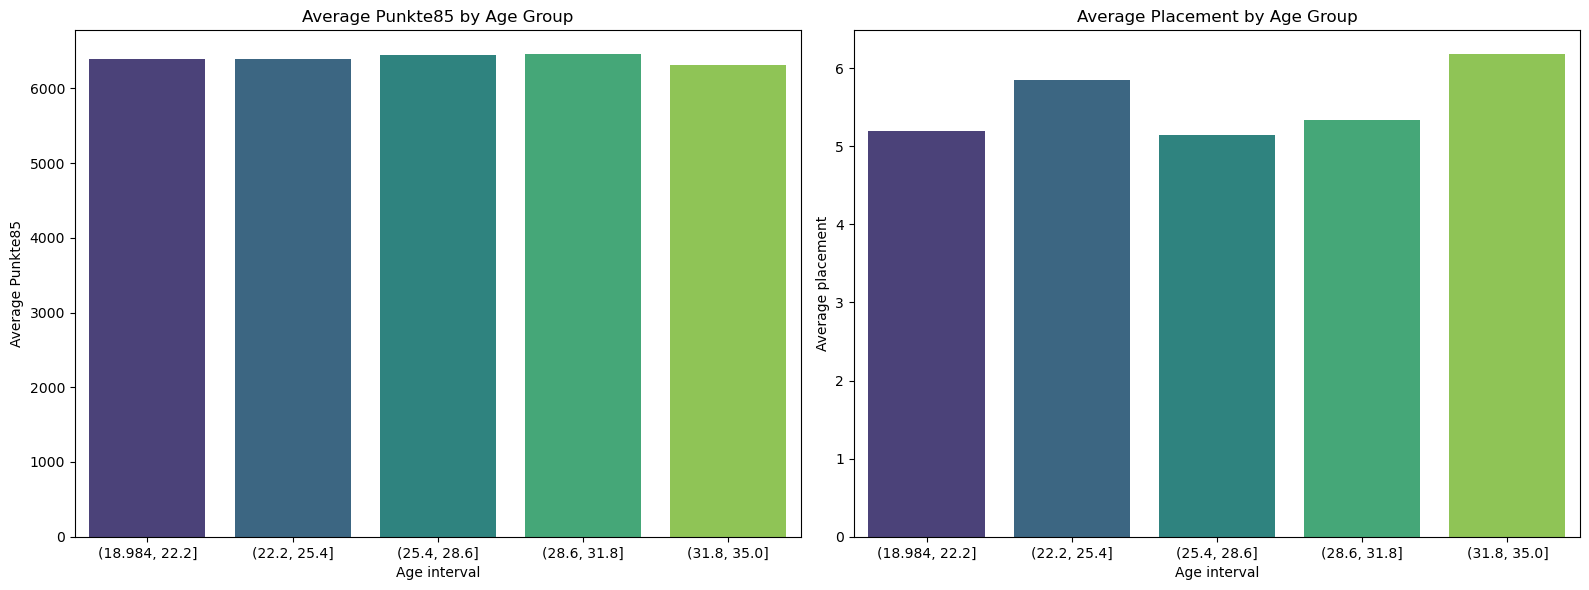

In [ ]:
# Explore how athlete age relates to overall performance points
age_points_summary = (
    df.dropna(subset=["age", "Punkte85"])
    .assign(
        age_group=lambda d: pd.cut(  # or use qcut??
            d["age"], bins=5, duplicates="drop"
        ).astype(str)
    )
    .groupby("age_group", observed=True)
    .agg(
        avg_points=("Punkte85", "mean"),
        avg_rank=("Platzierung", "mean"),
        starts=("Punkte85", "size"),
    )
    .reset_index()
    .sort_values("age_group")
)
print(age_points_summary)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(
    data=age_points_summary,
    x="age_group",
    y="avg_points",
    hue="age_group",
    palette="viridis",
    legend=False,
    ax=axs[0],
)
axs[0].set_title("Average Punkte85 by Age Group")
axs[0].set_xlabel("Age interval")
axs[0].set_ylabel("Average Punkte85")

sns.barplot(
    data=age_points_summary,
    x="age_group",
    y="avg_rank",
    hue="age_group",
    palette="viridis",
    legend=False,
    ax=axs[1],
)
axs[1].set_title("Average Placement by Age Group")
axs[1].set_xlabel("Age interval")
axs[1].set_ylabel("Average placement")
plt.tight_layout()
plt.show()

<!--Copliot explanation -->
To group athletes by age in this analysis, quantile-based cutting—`pd.qcut`—is the better fit. With `qcut` you specify the number of bins (say four quartiles), and pandas chooses breakpoints so each group contains roughly the same number of athletes. That keeps every bar in the plots based on a comparable sample size, which makes the contrasts between age brackets less sensitive to uneven participation. The regular `pd.cut`, by contrast, slices the axis into equal-width intervals; if the age distribution is skewed or concentrated, some bins can end up nearly empty and their averages become noisy. So switch the comment to `pd.qcut`, keep the quartile labels, and you’ll get balanced cohorts that make the performance comparisons more reliable.


In [ ]:
# Standardisieren Sie die Werte der 7 Disziplinen.

from sklearn.preprocessing import StandardScaler

df_std = df.copy()
df_std[disciplines] = StandardScaler().fit_transform(df_std[disciplines])

print(df_std[disciplines].describe())

       Zeit_100m_Huerden    Hochsprung   Kugelstoßen  Zeit_200m_Lauf  \
count       2.100000e+02  2.100000e+02  2.100000e+02    2.100000e+02   
mean       -5.142976e-15  6.682485e-16  1.404168e-15   -2.791418e-15   
std         1.002389e+00  1.002389e+00  1.002389e+00    1.002389e+00   
min        -2.389659e+00 -1.313291e+01 -2.350240e+00   -1.805326e+00   
25%        -5.590885e-01 -1.652697e-01 -6.940307e-01   -4.440524e-01   
50%        -1.291831e-02  5.328595e-02 -3.243490e-02   -9.186964e-02   
75%         4.552275e-01  2.718416e-01  5.536768e-01    4.176714e-01   
max         7.405393e+00  1.073212e+00  2.871482e+00    1.070341e+01   

         Weitsprung     Speerwurf  Zeit_800m_Lauf  
count  2.100000e+02  2.100000e+02    2.100000e+02  
mean  -1.909584e-15  1.463380e-15   -1.184238e-15  
std    1.002389e+00  1.002389e+00    1.002389e+00  
min   -3.403903e+00 -2.637443e+00   -2.215382e+00  
25%   -6.693486e-01 -5.930194e-01   -7.242919e-01  
50%   -3.010208e-02 -5.129059e-02   -6.

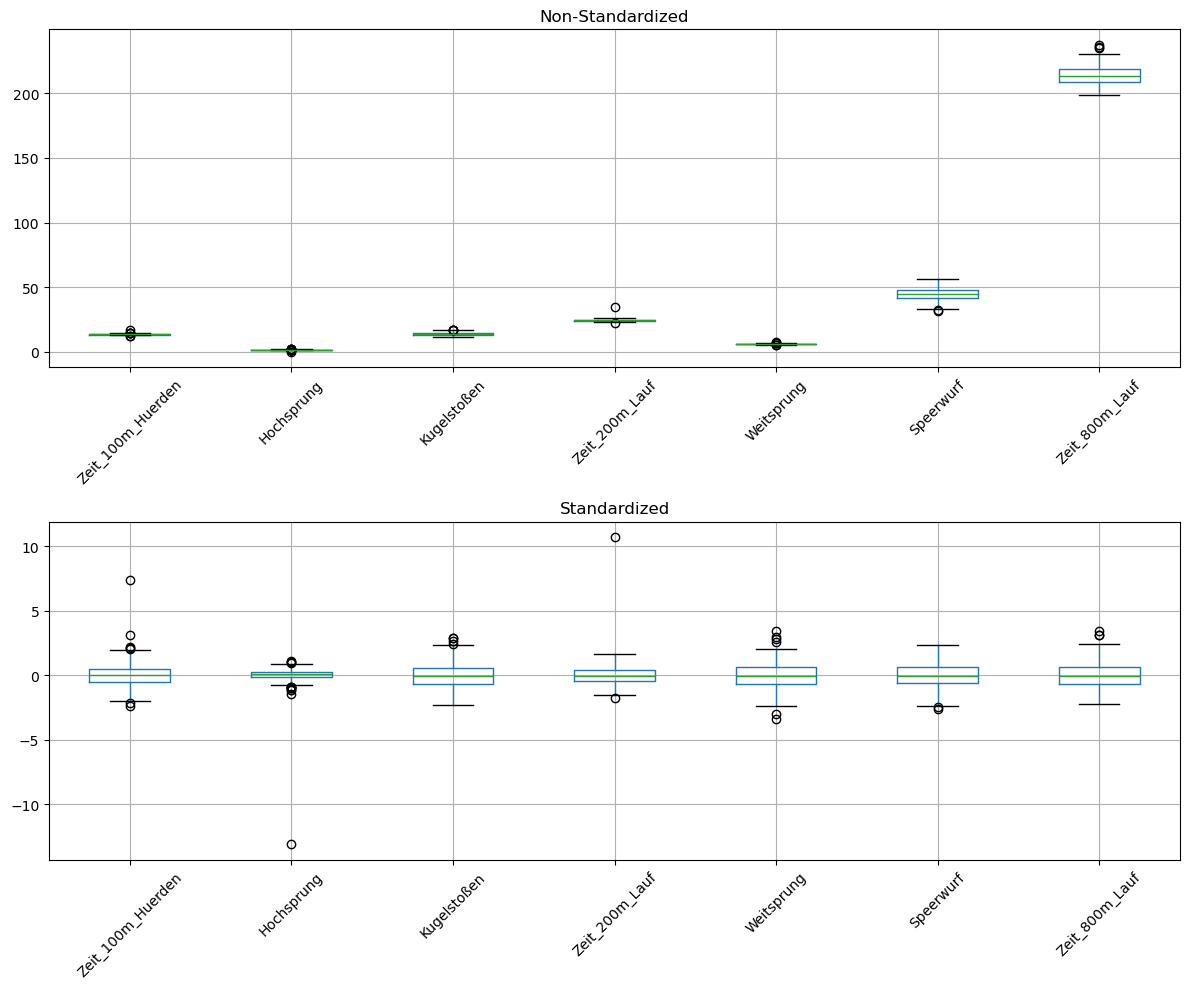

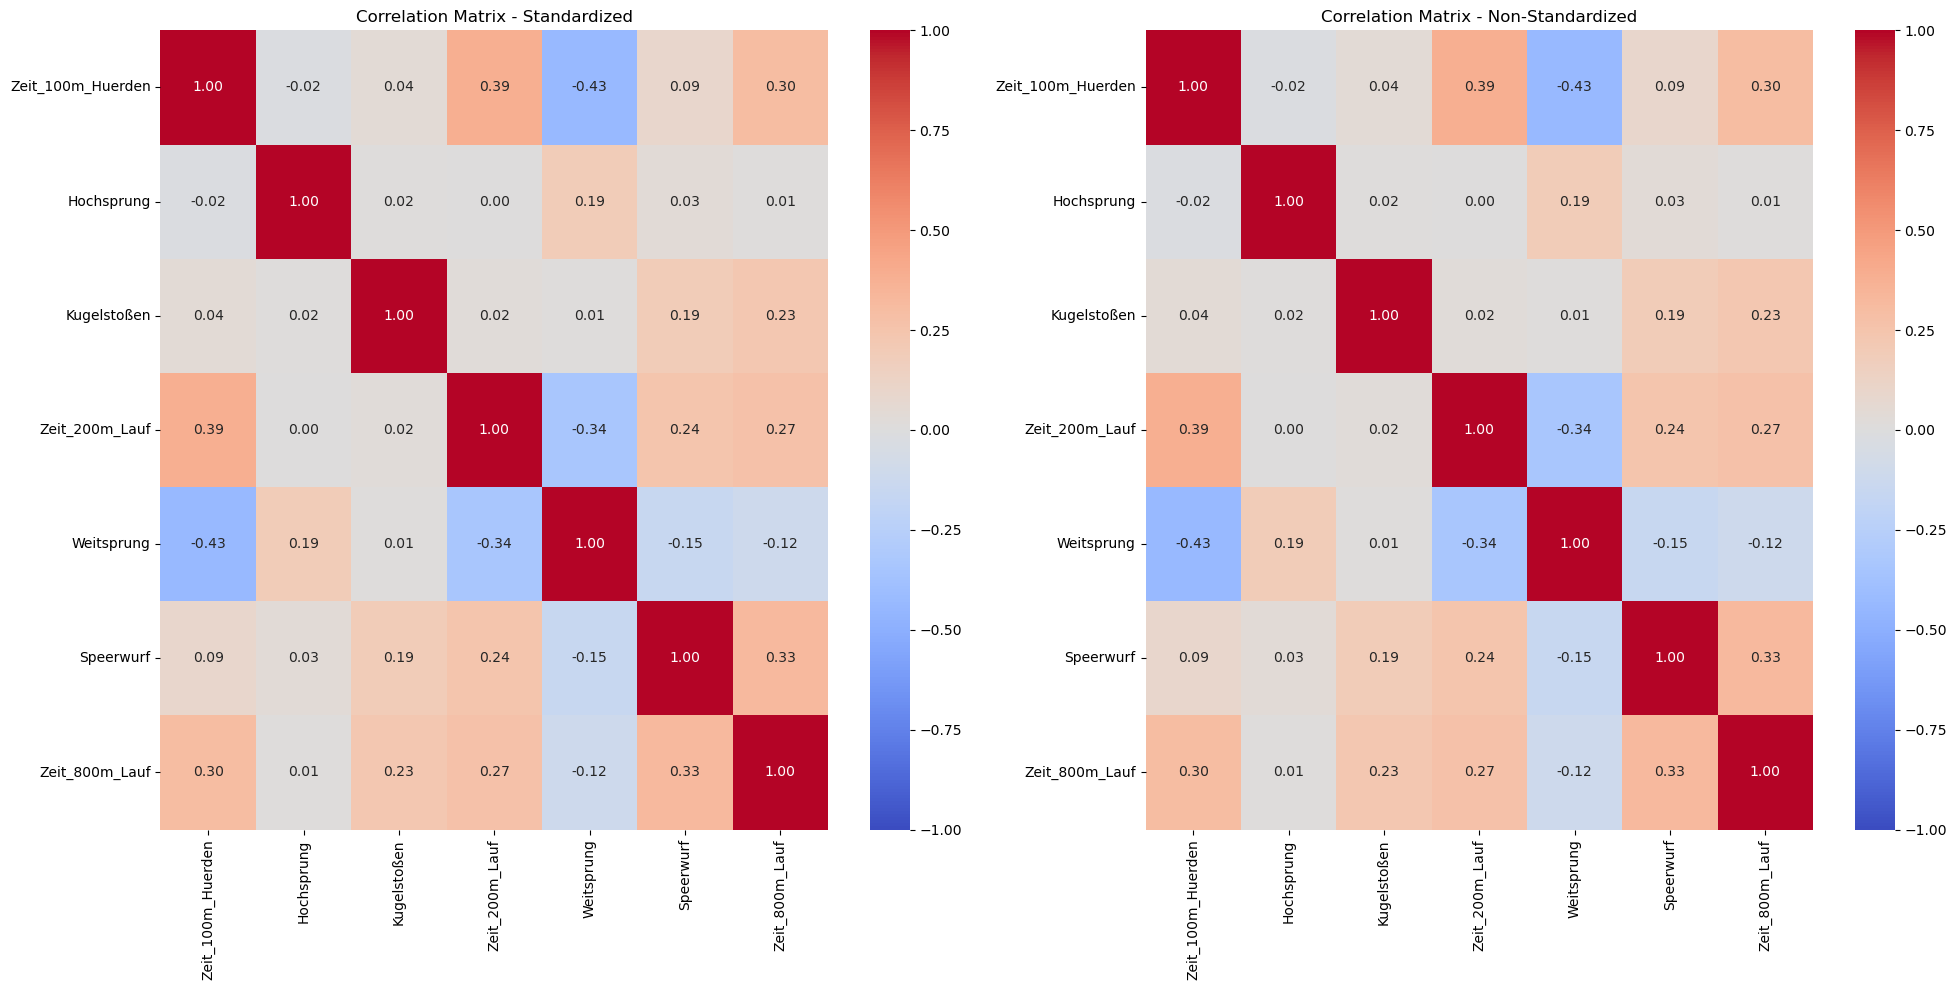

In [ ]:
_, axs = plt.subplots(2, 1, figsize=(12, 10))

df[disciplines].boxplot(ax=axs[0])
axs[0].set_title("Non-Standardized")
axs[0].tick_params(axis="x", rotation=45)

df_std[disciplines].boxplot(ax=axs[1])
axs[1].set_title("Standardized")
axs[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


_, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(
    df_std[disciplines].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    ax=axs[0],
)
axs[0].set_title("Correlation Matrix - Standardized")
sns.heatmap(
    df[disciplines].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    ax=axs[1],
)
axs[1].set_title("Correlation Matrix - Non-Standardized")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import t

crit_t = t.ppf(1 - 0.05 / 2, df=3).item()

print("Crit T:", crit_t)

mu = 56.25
s2 = 222.91
I_95 = mu

se = np.sqrt(s2 / 4).item()
print("SE:", se)

print("95% CI:", [mu - crit_t * se, mu + crit_t * se])

Crit T: 3.182446305284263
SE: 7.4650853980379885
95% CI: [32.492766556382506, 80.0072334436175]


In [ ]:
from scipy.stats import multivariate_normal

import numpy as np

# bivariate, no covariance
mu1 = np.array([2.0, 3.0])
S1 = np.array([[2.0, 0.0], [0.0, 3.0]])

# bivariate, positive covariance (bottom left - top right)
mu2 = np.array([2.0, 3.0])
S2 = np.array([[3.0, 2.0], [2.0, 3.0]])

# bivariate, negative covariance (top left - bottom right)
mu3 = np.array([2.0, 3.0])
S3 = np.array([[3.0, -2.0], [-2.0, 3.0]])

# trivariate
mu4 = np.array([2.0, 3.0, 4.0])
S4 = np.array([[2.0, 1.0, 1.0], [1.0, 3.0, -1.0], [1.0, -1.0, 4.0]])

mvn_params = [(mu1, S1), (mu2, S2), (mu3, S3), (mu4, S4)]

In [ ]:
def make_mvn(mu, cov, n=200) -> tuple[np.ndarray, np.ndarray]:
    rv = multivariate_normal(mean=mu, cov=cov)
    X = rv.rvs(size=n, random_state=0)
    fX = rv.pdf(X)
    return X, fX


mvns = list(map(lambda p: make_mvn(*p), mvn_params))

descriptions = ["no_cov", "pos_cov", "neg_cov", "trivariate"]
for (X, fX), desc in zip(mvns, descriptions):
    print(f"{desc}: X.shape={X.shape}, fX.shape={fX.shape}")

mvn_df = pd.concat(
    [
        pd.DataFrame(
            {
                "x1": X[:, 0],
                "x2": X[:, 1],
                "x3": X[:, 2] if X.shape[1] > 2 else np.nan,
                "fX": fX,
                "dist": descriptions[i],
            }
        )
        for i, (X, fX) in enumerate(mvns)
    ],
    ignore_index=True,
)
mvn_df.head()

no_cov: X.shape=(200, 2), fX.shape=(200,)
pos_cov: X.shape=(200, 2), fX.shape=(200,)
neg_cov: X.shape=(200, 2), fX.shape=(200,)
trivariate: X.shape=(200, 3), fX.shape=(200,)


,x1,x2,x3,fX,dist
0,2.565908,6.055428,NaN,0.012654,no_cov
1,5.169102,4.695224,NaN,0.003268,no_cov
2,0.617920,6.234705,NaN,0.007047,no_cov
3,1.785949,4.645601,NaN,0.040903,no_cov
4,2.580674,2.821220,NaN,0.059405,no_cov


In [ ]:
# by Copilot::GPT5-Codex
true_cov = pd.concat(
    [
        pd.DataFrame(
            cov,
            columns=[f"x{i+1}" for i in range(len(mu))],
            index=[f"x{i+1}" for i in range(len(mu))],
        )
        .stack()
        .rename("true_cov")
        .reset_index()
        .assign(dist=dist)
        for dist, (mu, cov) in zip(descriptions, mvn_params)
    ],
    ignore_index=True,
).rename(columns={"level_0": "row_dim", "level_1": "col_dim"})

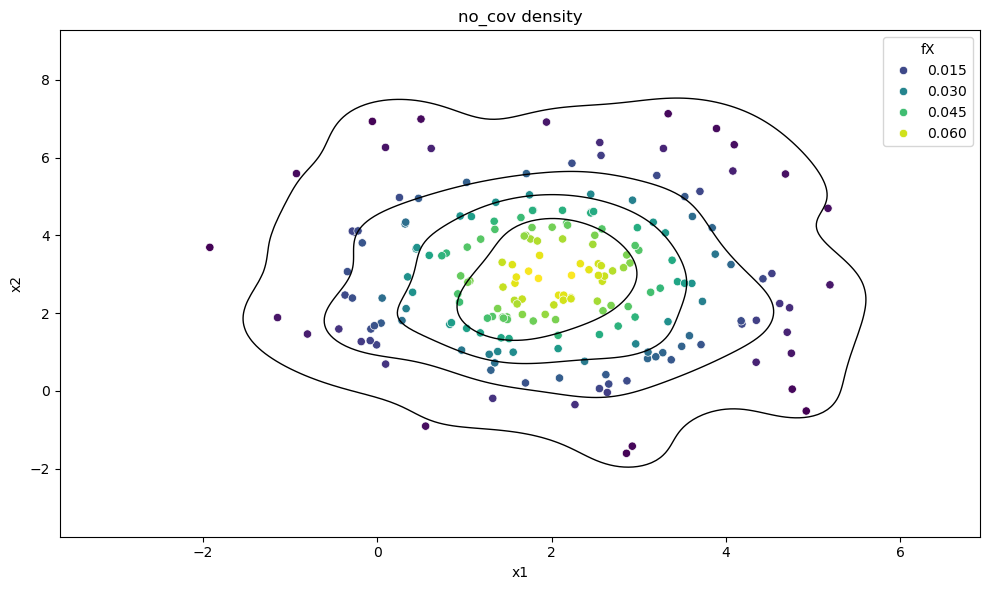

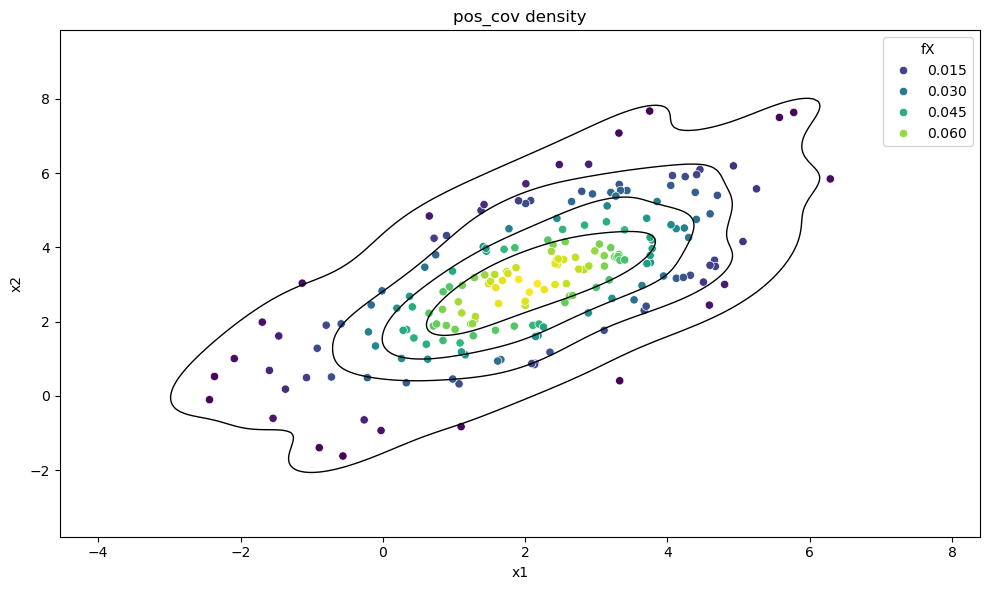

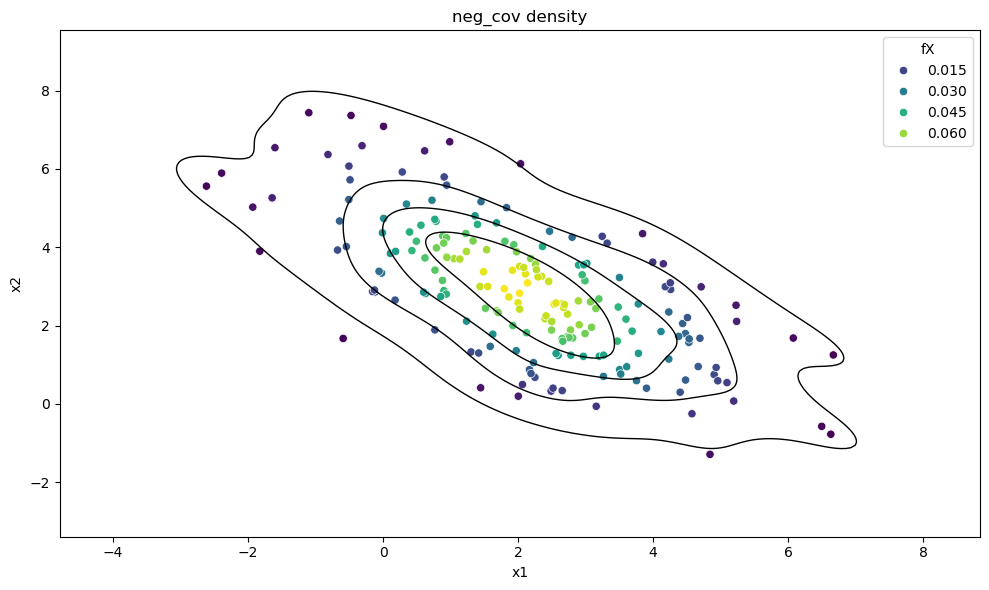

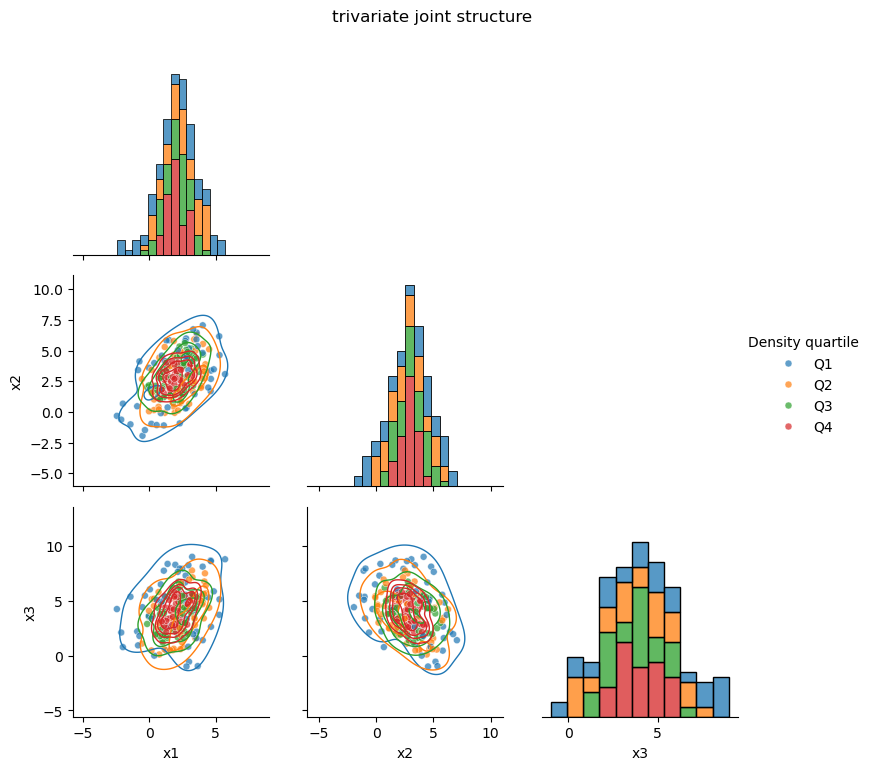

In [ ]:
for dist in mvn_df.dist.unique():
    df_sub = mvn_df.query("dist == @dist")
    if df_sub.x3.isna().all():
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_sub, x="x1", y="x2", hue="fX", palette="viridis")
        sns.kdeplot(data=df_sub, x="x1", y="x2", levels=5, color="k", linewidths=1)
        plt.title(f"{dist} density")
        plt.tight_layout()
        plt.show()
    else:
        # by Copilot::GPT5-Codex
        df_grid = df_sub.dropna(subset=["x1", "x2", "x3"]).assign(
            density_band=lambda d: pd.qcut(
                d["fX"],
                q=4,
                duplicates="drop",
                labels=["Q1", "Q2", "Q3", "Q4"],
            )
        )
        g = sns.PairGrid(
            df_grid, vars=["x1", "x2", "x3"], hue="density_band", corner=True
        )
        g.map_offdiag(sns.scatterplot, s=25, alpha=0.7)
        g.map_offdiag(
            sns.kdeplot, levels=5, color="k", linewidths=1, warn_singular=False
        )
        import seaborn as sns

        # Distplot Example
        # sns.set_theme(style="darkgrid")
        # df = sns.load_dataset("penguins")
        # sns.displot(
        #     df, x="flipper_length_mm", col="species", row="sex",
        #     binwidth=3, height=3, facet_kws=dict(margin_titles=True),
        # )
        g.map_diag(sns.histplot, kde=False, multiple="stack")
        g.add_legend(title="Density quartile")
        g.figure.suptitle(f"{dist} joint structure", y=1.02)

__Explanation of KDE contour levels by Copilot::GPT5-Codex__


Here’s what those contour levels are telling you in the KDE plots:

• For the bivariate panels, each black contour from `sns.kdeplot(... levels=5 …)` encloses a region where the estimated joint density of the sample is constant. Starting from the outermost line and moving inward, the density increases; points inside tighter contours correspond to parameter values with higher estimated probability under the fitted distribution.

• Because `levels=5` and we let seaborn pick the actual level heights, the library chooses five percentile cuts of the KDE surface. In practice, think of the outer contour as covering most observations, while each successive inner contour captures a smaller, denser subset. They’ll span areas of roughly equal mass (e.g., outer ≈ 80–90%, next ≈ 60–70%, etc.), though the exact percentages depend on the shape of the density surface.

• The coloring of the scatter points (either by `fX` or by the quartile labels `Q1–Q4`) complements those contours. Points plotted in warmer hues or higher quartiles fall into the regions circled by the inner contours—exactly where the KDE says the distribution allocates the most probability mass.

So, reading the plot, you scan inward: each contour you cross means “higher joint density,” and the innermost loop marks the tight core where the sample concentrates the most.

**Explanation on the univariate KDEs split by quantile by ChatGPT::GPT5**

Great question — and you’re thinking about it in the right way.

### What's being shown on the diagonal axes?

On the diagonal of the `PairGrid`, you’re seeing **univariate kernel density estimates (KDEs)** of the variables `x1`, `x2`, and `x3`, each **split by density quartile** (`Q1`, `Q2`, `Q3`, `Q4`).

### Does each quantile include only its own data, or cumulative?

In your code, you use:

```python
pd.qcut(d["fX"], q=4, duplicates="drop", labels=["Q1", "Q2", "Q3", "Q4"])
```

This **discretizes the continuous density values `fX` into four quartile bands**, and assigns each row a single label — `"Q1"`, `"Q2"`, etc.

That means:

* Each data point is assigned to exactly **one** quartile.
* For example, Q2 contains **only** the data points whose `fX` lies in the second quartile (i.e., between the 25th and 50th percentile of `fX`).
* There is **no cumulative inclusion** — Q2 does **not** include Q1.

### So what's shown on the diagonal?

Each KDE on the diagonal is showing the **distribution of `x1`, `x2`, or `x3`** but:

* **only using the data in that specific `density_band` (Q1–Q4).**
* That’s why each KDE curve is different per quartile — it’s showing how that variable is distributed for each conditional density quartile group.

For instance:

* The red curve for `Q4` shows how `x1` (or `x2`, `x3`) is distributed **among the most probable samples** (top 25% of density values).
* The blue curve for `Q1` shows how that same variable looks **in the least probable regions** (bottom 25%).

### Summary

| Question                                  | Answer                                                                           |
| ----------------------------------------- | -------------------------------------------------------------------------------- |
| Does each quartile only use its own data? | ✅ Yes — no cumulative inclusion. Each row belongs to exactly one quartile.       |
| What do the diagonal KDEs show?           | ✅ Marginal density of each variable **within each quartile group** of `fX`.      |
| What's the purpose?                       | ✅ It helps visualize how the marginal distributions change across density bands. |

Let me know if you want to overlay the true marginal densities for comparison — that can be an interesting diagnostic.
